<center><h1> Linear Value function approximation - Mountain Car</h1></center>

Following dennybritz exercise : 
https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation.ipynb


In [1]:
import gym
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from mpl_toolkits.mplot3d import Axes3D

In [2]:

env = gym.make('MountainCar-v0')
env.reset()
# done = False
# while not done:
#     env.render()
#     obs, reward, done, _ = env.step(np.random.randint(env.action_space.n))
#     print(reward)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.47457664,  0.        ])

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))


print(featurizer.transform(scaler.transform(observation_examples)).shape)

(1000, 400)


In [5]:

class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        ft = self.featurize_state(s)
        if a:
            return self.models[a].predict([ft])[0]
        else:
            return [self.models[a].predict([ft])[0] for a in range(len(self.models))]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])
        return None

In [6]:

def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn



def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    episode_lenghts = []
    episode_rewards = []
    total_ep_rewards = 0    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        #last_reward = stats.episode_rewards[i_episode - 1]

        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, total_ep_rewards), end="")
        sys.stdout.flush()

        state = env.reset()

        total_ep_rewards = 0

        for t in itertools.count():
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)

            total_ep_rewards += reward

            # TD update
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)

            estimator.update(state, action, td_target)

            if done:
                episode_lenghts.append(t)
                episode_rewards.append(total_ep_rewards)
                break
            
            state = next_state
    
    return episode_lenghts, episode_rewards

Episode 200/200 (-151.0)

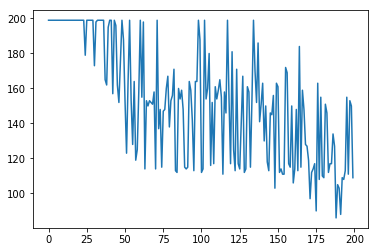

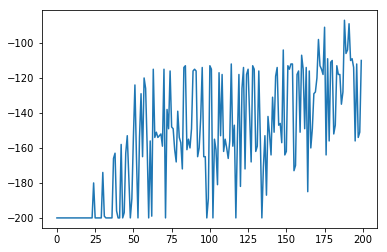

In [7]:
estimator = Estimator()
episode_lengths, episode_rewards = q_learning(env, estimator, 200, epsilon=0.0)

plt.plot(episode_lengths)
plt.show()

plt.plot(episode_rewards)
plt.show()

In [8]:
def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


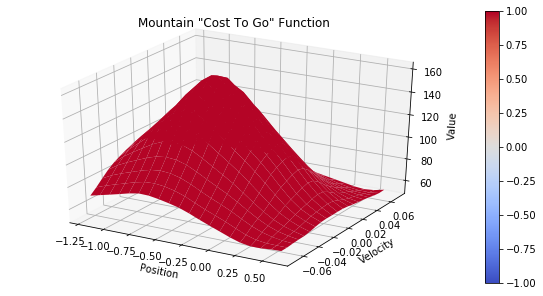

In [9]:
plot_cost_to_go_mountain_car(env, estimator)

In [10]:

env = gym.make('MountainCar-v0')
obs = env.reset()

policy = make_epsilon_greedy_policy(estimator, 0, env.action_space.n)

done = False
while not done:
    env.render()
    action_probs = policy(obs)
    action = np.argmax(action_probs)
    obs, reward, done, _ = env.step(action)



WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
